In [2]:
## importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

In [28]:
## parameters

# find maximum x and y values (all example images have same shape)
image = mpimg.imread('test_images/solidWhiteRight.jpg')
y_max, x_max, _ = image.shape

# ROI y value
y_min = 310

# define length of ROI top (the higher the number the shorter the top region, number must be odd)
top_len_val = 21 # odd number expected
top_left_num = int(top_len_val/2)
top_right_num = int(top_len_val/2)+1

## select region of interest: 
# determine polygon vertices:
top_left = np.array([top_left_num*int(x_max/top_len_val), y_min])
top_right = np.array([top_right_num*int(x_max/top_len_val), y_min])
bottom_left = np.array([0, y_max])
bottom_right = np.array([x_max, y_max])
# apex = np.array([round(x_max/2), round(y_max/2)])
vertices = np.array([[bottom_left, bottom_right, top_right, top_left]])

In [29]:
## functions

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


In [30]:
#Functions2

def get_line_params(line):
    # function takes a single line (2 extreme points: x0(line[0,0]), y0(line[0,1]), x1(line[0,2]), y1(line[0,3]))
    # and returns the slope and offset as two separate variables (y=mx+b)
    ### how to get rid of the second dimension? (first zero)
    m = (line[0,3]-line[0,1])/(line[0,2]-line[0,0])
    b = ((line[0,2]*line[0,1]-line[0,0]*line[0,3])/(line[0,2]-line[0,0]))
    return m, b

def average_left_right(lines):
    # separate if lines are left (slope<0) or right (slope>0) from car
    # initialize parameteres for both left and right lanes
    num_left = 0
    m_left = 0
    b_left = 0
    num_right = 0
    m_right = 0
    b_right = 0
    # initialize min and max values of lines:
    min_y, min_x = image.shape[0:2]
    max_x = max_y = 0
    for line in lines:
        m, b = get_line_params(line)
        if m < 0: # lines on the left
            num_left += 1 # increment left line counter
            m_left += m # add slope value to the others as part of averaging
            b_left += b # add offset value to the others as part of averaging
        elif m > 0: # lines on the right
            num_right += 1 # increment right line counter
            m_right += m # add slope value to the others
            b_right += b # add offset value to the others as part of averaging
    # calculate average slopes and offsets:
    if num_left > 0:
        m_avg_left = m_left / num_left
        b_avg_left = b_left / num_left
    else:
        print('no left lines detected')
        m_avg_left = np.inf
        b_avg_left = 0
    if num_right > 0:
        m_avg_right = m_right / num_right
        b_avg_right = b_right / num_right
    else:
        print('no right lines detected')
        m_avg_right = np.inf
        b_avg_right = 0
    return m_avg_left, b_avg_left, m_avg_right, b_avg_right

def calc_line_x_val(m, b, y):
    # returns the x value of a line at a given y value
    x = (y - b) / m
    return int(x)

# def extrapolate(m, b, y):
#     x_min = calc_line_x_val(m, b, y)
#     x_max = 

def extrapolate(m_avg_left, b_avg_left, m_avg_right, b_avg_right):
    # determine limit of extrapolated lines (y_max is defined above with shape function)
    x_min_left = calc_line_x_val(m_avg_left, b_avg_left, y_min)
    x_max_left = calc_line_x_val(m_avg_left, b_avg_left, y_max)
    x_min_right = calc_line_x_val(m_avg_right, b_avg_right, y_min)
    x_max_right = calc_line_x_val(m_avg_right, b_avg_right, y_max)
    return x_min_left, x_max_left, x_min_right, x_max_right



# Example with one image

475 485


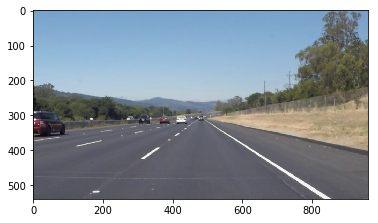

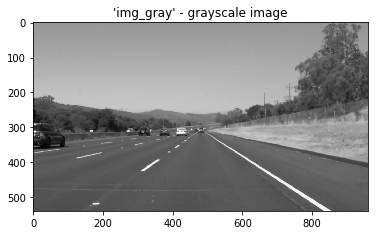

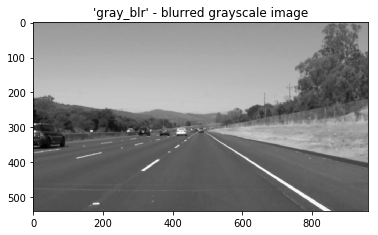

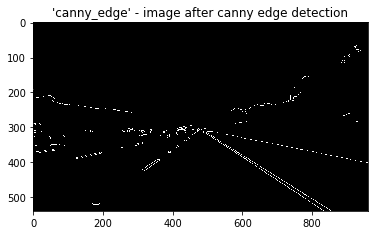

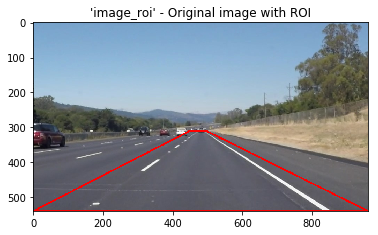

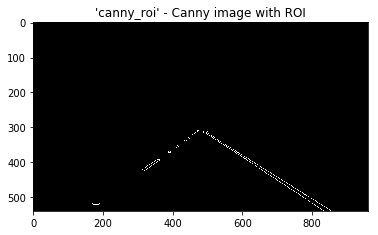

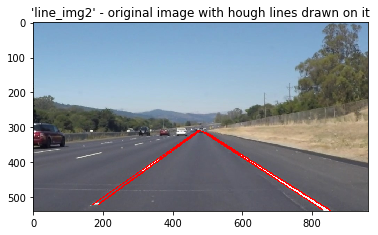

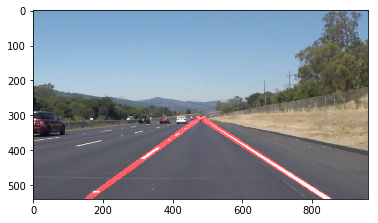

In [58]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(image)

# convert image into grayscale
img_gray = grayscale(image)
plt.figure()
plt.imshow(img_gray, cmap='gray')
plt.title('\'img_gray\' - grayscale image')

# blur image
gray_blr = gaussian_blur(img_gray, 5)
plt.figure()
plt.imshow(gray_blr, cmap='gray')
plt.title('\'gray_blr\' - blurred grayscale image')

# apply canny edge detector
th_low = 100; #50
th_high = 200; #150
plt.figure()
canny_edge = canny(gray_blr, th_low, th_high)
plt.imshow(canny_edge, cmap='gray')
plt.title('\'canny_edge\' - image after canny edge detection')
#cv2.imwrite('test_images_output/canny_edge_100-200.jpg',canny_edge)

# visualize ROI
image_roi = np.copy(image)
pts = np.array([[top_left, bottom_left, bottom_left, bottom_right, bottom_right, top_right, top_right, top_left]])
cv2.polylines(image_roi, pts, True, [255, 0, 0], 3)
plt.figure()
plt.imshow(image_roi)
plt.title('\'image_roi\' - Original image with ROI')

# Apply ROI on canny edge image
canny_roi = region_of_interest(canny_edge, vertices)
plt.figure()
plt.imshow(canny_roi, cmap='gray')
plt.title('\'canny_roi\' - Canny image with ROI')

# hough transform: ### parameters to detect complete lines only with hough-transform: #threshold = 70 #min_line_len = 100 #max_line_gap = 140
rho = 1
theta = 1 * np.pi/180
threshold = 50
min_line_len = 10
max_line_gap = 140

# Probabilistic Hough Line Transform (outputs the extremes of the detected lines)
lines = cv2.HoughLinesP(canny_roi, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
# create copy of image
line_img2 = np.copy(image)
# draws lines on passed image
draw_lines(line_img2, lines, color=[255, 0, 0], thickness=2)
plt.figure()
plt.imshow(line_img2)
plt.title('\'line_img2\' - original image with hough lines drawn on it')

# average lines
m_avg_left, b_avg_left, m_avg_right, b_avg_right = average_left_right(lines)

# extrapolate lines
x_min_left, x_max_left, x_min_right, x_max_right = extrapolate(m_avg_left, b_avg_left, m_avg_right, b_avg_right)
print(x_min_left, x_min_right)
#lines_final = np.array([[[x_left_max, y_max, x_left_min, y_left_min]],[[x_right_max, y_max, x_right_min, y_right_min]]])
lines_final = np.array([[[x_min_left, y_min, x_max_left, y_max], [x_min_right, y_min, x_max_right, y_max]]])
image_copy = np.copy(image)

image_black = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(image_black, lines_final, [255, 0, 0], 13)

overlay = weighted_img(image_black, image_copy, 1, 1, 0)
plt.figure()
plt.imshow(overlay)

In [59]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # convert into grayscale image
    img_gray = grayscale(image)
    
    # blur image
    gray_blr = gaussian_blur(img_gray, 5)
    
    # apply canny edge detector
    canny_edge = canny(gray_blr, th_low, th_high)
    
    # keep only region of interest
    # (ROI was selected after canny edge detection because otherwise edges are detected at the boundaries of ROI)
    canny_roi = region_of_interest(canny_edge, vertices)
    
    # Probabilistic Hough Line Transform (outputs the extremes of the detected lines)
    lines = cv2.HoughLinesP(canny_roi, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    # average left and right lane lines
    m_avg_left, b_avg_left, m_avg_right, b_avg_right = average_left_right(lines)
        
    # extrapolate lines
    x_min_left, x_max_left, x_min_right, x_max_right = extrapolate(m_avg_left, b_avg_left, m_avg_right, b_avg_right)
    
#     # calculate line extremes
#     x_min_left = calc_line_x_val(m_avg_left, b_avg_left, y_min)
#     x_max_left = calc_line_x_val(m_avg_left, b_avg_left, y_max)
#     x_min_right = calc_line_x_val(m_avg_right, b_avg_right, y_min)
#     x_max_right = calc_line_x_val(m_avg_right, b_avg_right, y_max)

    # calculate final lines (averaged and extrapolated)
    #lines_final = np.array([[[x_left_max, y_max, x_left_min, y_left_min]],[[x_right_max, y_max, x_right_min, y_right_min]]])
    lines_final = np.array([[[x_min_left, y_min, x_max_left, y_max], [x_min_right, y_min, x_max_right, y_max]]])

    image_copy = np.copy(image)

    image_black = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(image_black, lines_final, [255, 0, 0], 13)

    image_final = weighted_img(image_black, image_copy, 1, 1, 0)
    
    return image_final

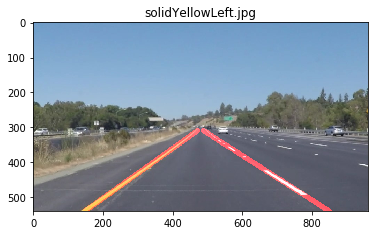

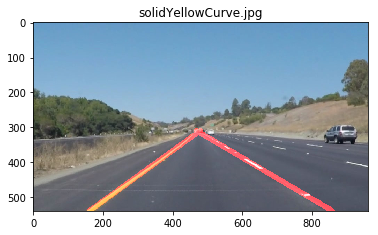

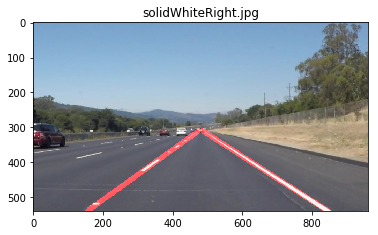

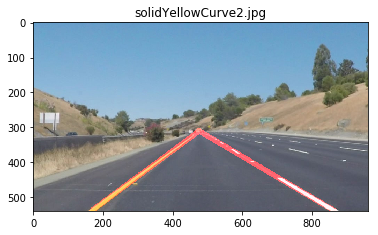

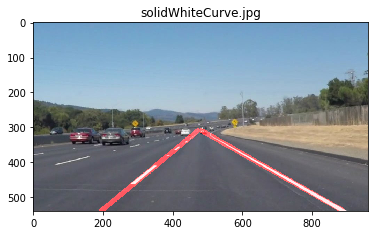

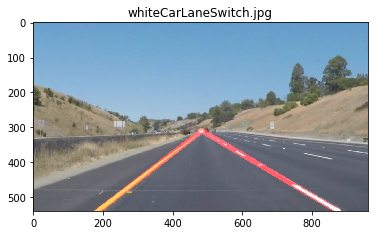

In [60]:
image_names = os.listdir("test_images/")

## read image:
for image_name in image_names:
    image = mpimg.imread('test_images/'+image_name)
    image_final = process_image(image)
    # plot rgb-image:
    plt.figure()
    plt.imshow(image_final)
    plt.title(image_name)

In [61]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [65]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 68%|██████▊   | 150/222 [00:09<00:05, 12.64it/s]

no left lines detected


 79%|███████▉  | 176/222 [00:11<00:03, 13.15it/s]

no left lines detected


 95%|█████████▌| 212/222 [00:13<00:00, 13.27it/s]

no left lines detected


100%|█████████▉| 221/222 [00:14<00:00, 15.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.25 s, sys: 217 ms, total: 3.46 s
Wall time: 16.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [64]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  5%|▌         | 37/682 [00:00<00:16, 39.50it/s]

no right lines detected


100%|█████████▉| 681/682 [00:48<00:00, 14.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.9 s, sys: 647 ms, total: 10.5 s
Wall time: 50.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [66]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

no right lines detected
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:12, 19.50it/s]

no right lines detected
no right lines detected
no right lines detected


  5%|▌         | 13/251 [00:00<00:11, 20.02it/s]

no right lines detected
no right lines detected
no right lines detected
no right lines detected


  7%|▋         | 18/251 [00:00<00:11, 20.09it/s]

no right lines detected
no right lines detected


 10%|▉         | 25/251 [00:01<00:11, 19.88it/s]

no right lines detected
no right lines detected
no right lines detected
no right lines detected
no right lines detected


 12%|█▏        | 29/251 [00:01<00:11, 19.59it/s]

no right lines detected


 16%|█▌        | 39/251 [00:01<00:11, 19.26it/s]

no right lines detected


 18%|█▊        | 45/251 [00:02<00:21,  9.77it/s]

no right lines detected


 20%|█▉        | 49/251 [00:03<00:24,  8.16it/s]

no right lines detected


 21%|██        | 52/251 [00:03<00:26,  7.45it/s]

no right lines detected


 23%|██▎       | 58/251 [00:04<00:27,  6.92it/s]

no right lines detected


 24%|██▍       | 60/251 [00:04<00:27,  6.82it/s]

no right lines detected
no right lines detected


 27%|██▋       | 69/251 [00:06<00:26,  6.93it/s]

no right lines detected


 32%|███▏      | 80/251 [00:07<00:27,  6.28it/s]

no right lines detected
no right lines detected


 33%|███▎      | 82/251 [00:08<00:27,  6.15it/s]

no right lines detected
no right lines detected


 33%|███▎      | 84/251 [00:08<00:26,  6.23it/s]

no right lines detected


 37%|███▋      | 92/251 [00:09<00:25,  6.20it/s]

no right lines detected
no right lines detected


 37%|███▋      | 94/251 [00:10<00:25,  6.22it/s]

no right lines detected
no right lines detected


 38%|███▊      | 96/251 [00:10<00:24,  6.21it/s]

no right lines detected
no right lines detected


 41%|████▏     | 104/251 [00:11<00:23,  6.25it/s]

no right lines detected
no right lines detected


 42%|████▏     | 106/251 [00:12<00:22,  6.48it/s]

no right lines detected
no right lines detected


 43%|████▎     | 108/251 [00:12<00:23,  6.21it/s]

no right lines detected
no right lines detected


 44%|████▍     | 110/251 [00:12<00:22,  6.31it/s]

no right lines detected


 47%|████▋     | 119/251 [00:14<00:23,  5.53it/s]

no right lines detected


 49%|████▊     | 122/251 [00:14<00:22,  5.73it/s]

no right lines detected


 53%|█████▎    | 133/251 [00:16<00:21,  5.51it/s]

no right lines detected


 70%|███████   | 176/251 [00:24<00:13,  5.66it/s]

no right lines detected
no right lines detected


 71%|███████   | 178/251 [00:24<00:13,  5.45it/s]

no right lines detected


 72%|███████▏  | 181/251 [00:25<00:13,  5.06it/s]

no right lines detected


 75%|███████▍  | 187/251 [00:26<00:12,  5.11it/s]

no right lines detected


 75%|███████▍  | 188/251 [00:26<00:11,  5.33it/s]

no right lines detected
no right lines detected


 76%|███████▌  | 191/251 [00:26<00:10,  5.52it/s]

no right lines detected


 80%|███████▉  | 200/251 [00:28<00:08,  6.16it/s]

no right lines detected
no right lines detected


 80%|████████  | 202/251 [00:28<00:07,  6.23it/s]

no right lines detected


 84%|████████▍ | 212/251 [00:30<00:06,  6.34it/s]

no right lines detected
no right lines detected


 85%|████████▌ | 214/251 [00:30<00:05,  6.37it/s]

no right lines detected
no right lines detected


 88%|████████▊ | 222/251 [00:31<00:04,  6.79it/s]

no right lines detected
no right lines detected


 89%|████████▉ | 224/251 [00:32<00:04,  6.65it/s]

no right lines detected
no right lines detected


 93%|█████████▎| 234/251 [00:33<00:02,  6.71it/s]

no right lines detected
no right lines detected


 94%|█████████▍| 237/251 [00:34<00:02,  6.73it/s]

no right lines detected


 98%|█████████▊| 246/251 [00:35<00:00,  6.78it/s]

no right lines detected
no right lines detected


100%|██████████| 251/251 [00:36<00:00,  6.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.17 s, sys: 464 ms, total: 7.63 s
Wall time: 39.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))